# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle
from sklearn.model_selection import train_test_split

# TODO: Fill this in based on where you saved the training and testing data

training_file = '/Users/gfrias/Downloads/traffic-signs-data/train.p'
testing_file = '/Users/gfrias/Downloads/traffic-signs-data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']

X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.2, random_state=0)
X_test, y_test = test['features'], test['labels']

assert(len(X_train) == len(y_train))
assert(len(X_validation) == len(y_validation))
assert(len(X_test) == len(y_test))

print()
print("Image shape: {}".format(X_train[0].shape))
print()
print("Training Set: {} samples".format(len(X_train)))
print("Validation Set: {} samples".format(len(X_validation)))
print("Test Set: {} samples".format(len(X_test)))



Image shape: (32, 32, 3)

Training Set: 31367 samples
Validation Set: 7842 samples
Test Set: 12630 samples


---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [2]:
def print_summary(feature_set, feature_set_name):
    print("Summary for feature set: {}".format(feature_set_name))
    print("-----------------------")
    print("features shape: {}".format(feature_set['features'].shape))
    print("labels shape: {}".format(feature_set['labels'].shape))
    print("sizes shape: {}".format(feature_set['sizes'].shape))
    print("coord shape: {}".format(feature_set['coords'].shape))
    print()
    
print_summary(train, 'train')
print_summary(test, 'test')

Summary for feature set: train
-----------------------
features shape: (39209, 32, 32, 3)
labels shape: (39209,)
sizes shape: (39209, 2)
coord shape: (39209, 4)

Summary for feature set: test
-----------------------
features shape: (12630, 32, 32, 3)
labels shape: (12630,)
sizes shape: (12630, 2)
coord shape: (12630, 4)



Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

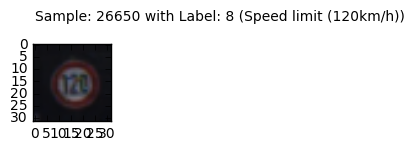

In [3]:
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl 

mpl.rcParams.update({'figure.max_open_warning': 0})
%matplotlib inline

def load_label_descriptions(filename):
    ret = {}
    
    f = open(filename)
    for line in f:
        v = line.rstrip().split(',')
        ret[v[0]] = v[1]
        
    return ret

def show_sample(X, y, index):
    s = "Sample: {} with Label: {} ({})".format(index, y[index], label_descriptions[str(y[index])])
    
    image = X[index].squeeze()
    
    plt.figure(figsize=(1,1))
    plt.text(0, -10, s)
    plt.imshow(image, cmap="gray") 
    
label_descriptions = load_label_descriptions('signnames.csv')
index = random.randint(0, len(X_train))

show_sample(X_train, y_train, index)

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [4]:
import cv2
from sklearn.utils import shuffle

#normalize image: (values around zero mean as discussed in the lecture)
def normalize(Xs):
    return np.array(list(map(lambda x: (x.astype('float32')-128)/128, Xs)))

#as in the paper cited, converting images to grayscale improved signals recognition, 
#reduced the amount of input parameters
def to_grayscale(rgb):
    #converting to grayscale using a similar approach to MatLab
    #https://nl.mathworks.com/help/matlab/ref/rgb2gray.html
    ret = np.dot(rgb[...,:3], [0.299, 0.587, 0.114])
    
    return np.expand_dims(ret, axis=4)

X_train = normalize(to_grayscale(X_train))
X_validation = normalize(to_grayscale(X_validation))
X_test = normalize(to_grayscale(X_test))

### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:**
First of all, I converted the images to grayscale, after reading the cited paper for the base line model since it ackknowledges better results than using the RGB space which I also confirmed while exploring with the validation set.
After that, I also normalized the values around 0 mean as discussed during the lectures since this it is believed to provide better numerical stability and also improved (although slightly) the results.
Since the images provided were all 32x32, no addional padding was required as in the LeNet lab (where they were 28x28)

### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**

The validation set was 'generated' by splitting the given train set in 80/20 for training and validation respectively by using the _train_test_split_ function
The test set was left untouched from the one provided (except for grayscale and normalization transformations)

In [5]:
import tensorflow as tf
from tensorflow.contrib.layers import flatten

def LeNet(x):
    mu = 0
    sigma = 0.1
    
    #Layer 1: Convolutional, input = 32x32x1, output = 28x28x6
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5,5,1,6), mean=mu, stddev=sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1 = tf.nn.conv2d(x, conv1_W, strides = [1,1,1,1], padding='VALID') + conv1_b
    
    #Activation 1
    conv1 = tf.nn.relu(conv1)
    
    #Pooling. Input=28x28x6, output=14x14x6
    conv1 = tf.nn.max_pool(conv1, ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID')
    
    #Layer 2: Convolutional. Output 10x10x16
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5,5,6,16), mean=mu, stddev=sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2 = tf.nn.conv2d(conv1, conv2_W, strides=[1,1,1,1], padding='VALID') + conv2_b
    
    #Activation 2
    conv2 = tf.nn.relu(conv2)
    
    #Pooling. Input=10x10x16. Output=5x5x16
    conv2 = tf.nn.max_pool(conv2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID')
    
    #Flatten. Input=5x5x16. Output=400
    fc0 = flatten(conv2)
    
    #Layer 3: Fully connected. Input = 400. Output = 120
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400,120), mean=mu, stddev=sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1 = tf.matmul(fc0, fc1_W) + fc1_b
    
    #Activation
    fc1 = tf.nn.relu(fc1)
    
    #Layer 4: Fully connected. Input = 120. Output = 84
    fc2_W = tf.Variable(tf.truncated_normal(shape=(120,84), mean=mu, stddev=sigma))
    fc2_b = tf.Variable(tf.zeros(84))
    fc2 = tf.matmul(fc1, fc2_W) + fc2_b
    
    #Activation
    fc2 = tf.nn.relu(fc2)

    #Layer 5: Fully Connected. Input = 84. Output = 43
    fc3_W = tf.Variable(tf.truncated_normal(shape=(84,43), mean=mu, stddev=sigma))
    fc3_b = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

In [6]:
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))

one_hot_y = tf.one_hot(y, 43)

In [7]:
rate = 0.001

logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate=rate)
training_operation = optimizer.minimize(loss_operation)

In [8]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_prediction = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

def evaluate(X_data, y_data, batch_size):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, batch_size):
        batch_x, batch_y = X_data[offset:offset+batch_size], y_data[offset:offset+batch_size]
        accuracy = sess.run(accuracy_prediction, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
        
    return total_accuracy / num_examples

In [9]:
EPOCHS = 10
BATCH_SIZE = 128

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x:batch_x, y:batch_y})
            
        validation_accuracy = evaluate(X_validation, y_validation, BATCH_SIZE)
        
        print("EPOCH {}...". format(i+1))
        print("Validation accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    try:
        saver
    except NameError:
        saver = tf.train.Saver()
    saver.save(sess, 'lenet')
    print("Model saved")

Training...

EPOCH 1...
Validation accuracy = 0.798

EPOCH 2...
Validation accuracy = 0.887

EPOCH 3...
Validation accuracy = 0.909

EPOCH 4...
Validation accuracy = 0.948

EPOCH 5...
Validation accuracy = 0.953

EPOCH 6...
Validation accuracy = 0.966

EPOCH 7...
Validation accuracy = 0.962

EPOCH 8...
Validation accuracy = 0.972

EPOCH 9...
Validation accuracy = 0.968

EPOCH 10...
Validation accuracy = 0.976

Model saved


In [10]:
done_training = 1

if (done_training):
    with tf.Session() as sess:
        saver.restore(sess, tf.train.latest_checkpoint('.'))

        test_accuracy = evaluate(X_test, y_test, BATCH_SIZE)
        print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.906


### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

The architecture used is based on the LeNet lab, it consists of 2 convolutional layers (with ReLu activation and Max pooling), flattening and 3 fully conectted layers for the final classification.

* Layer 1: Convolutional, input = 32x32x1, output = 28x28x6
* ReLu Activation 1
* Max Pooling. Input=28x28x6, output=14x14x6

* Layer 2: Convolutional. Output 10x10x16
* ReLu Activation 2
* Max Pooling. Input=10x10x16. Output=5x5x16

* Flatten. Input=5x5x16. Output=400

* Layer 3: Fully connected. Input = 400. Output = 120
* ReLu Activation 3

* Layer 4: Fully connected. Input = 120. Output = 84
* ReLu Activation 4

* Layer 5: Fully Connected. Input = 84. Output = 43


### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

The used optimizer is the AdamOptimizer since it provided a slightly better performance than gradient descent. Batch size = 128 and epochs = 10, several tests were done increasing the batch size and number of epochs without significant accuracy improvement and making the training phase longer so they were ruled out.
As for the learning rate hyperparameter, by making it larger (in an order of magnitude) it increased the accuracy in the earlier epoch stages but made it unstable and less reliable by the last couple of epochs. Reducing the value in 10x would cause the training rate to be slower and less accurate, even extending the # of epochs.

The original value of 0.001 turned out to be a good compromise.

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**

I started of by using the LeNet archicture from the MNIST digit recognition and extending it so that it will fit the new input and the amount of final clasification labels.
After running it a few times with default parameters, I tried changing learning rate to a faster one, to a slower one, changing the number of epochs and batch sizes.
Also I tried normalizing the RGB image as discussed in the lectures, converting it to graycale with and without normalization and found that the best combination was the normalized grayscale on the validation set.

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [11]:
import matplotlib.image as mpimg
import os

directory = 'streetview_imgs/'

imgs = []
labels = []

files = [f for f in os.listdir(directory) if os.path.isfile(directory + f) and f.endswith('png')]
for f in files:
    img = cv2.imread(directory + f, 1)
    label, _ = f.split('.')[0].split('_')
    
    img = normalize(to_grayscale(img))
    imgs.append(img)
    labels.append(label)

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**
The images were taken from Google Streetview, manually centered cropped in the sign and reduced to 32x32 RGB png color. The rest of the preprocessing is of course the same as for the training/validation/test sets.
The images in general are sharp and not twisted/tilted (were taken when front facing the signs as much as possible) 

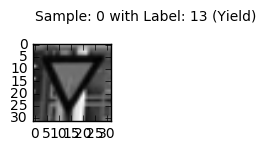

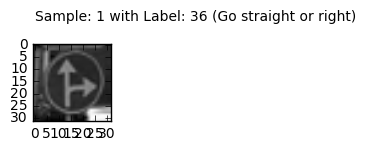

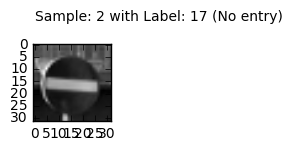

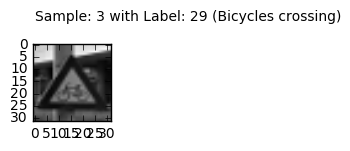

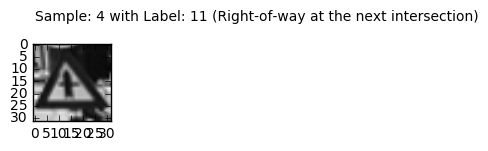

In [21]:
idx = np.random.choice(np.arange(len(imgs)), 5, replace=False)

test_imgs = [imgs[i] for i in idx]
test_labels = [int(labels[i]) for i in idx]

for i in range(len(test_imgs)):
    show_sample(test_imgs, test_labels, i)

### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


##### **Answer:**
Based on 22 images taken from the street signs in Google Street View, the accuracy is around 85% which is less than the ~90% from the test set.
For the 5 randomly picked images, it is 80%.
In order to see what to do with this differences, things like brightness, contrast and image distortion should be thought of by adding preprocessing or making the network more robust by adding layers. The last image (Right-of-way in next intersection) is considerably sharper and brighter than the samples. We could consider some image processing techniques like histogram normalization preprocessing for the training set.

In [23]:
def test_accuracy(imgs, labels):
    X_new = np.array(imgs)
    y_new = np.array(labels)

    print ("Testing accuracy on {} images...".format(len(imgs)))
    with tf.Session() as sess:
        tf.train.Saver().restore(sess, tf.train.latest_checkpoint('.'))
        accuracy = evaluate(X_new, y_new, len(X_new))
        print("accuracy: {}".format(accuracy))
        print()
        
test_accuracy(imgs, labels)
test_accuracy(test_imgs, test_labels)

Testing accuracy on 21 images...
accuracy: 0.8571428656578064

Testing accuracy on 5 images...
accuracy: 0.800000011920929



### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:**

As it can be seen in the last block code below, for image #5, the label prediction is far off ('11' is 5th place)
This means the prediction is really innacurate for this image, and leaves room for further improvements discussed in Answer 7.

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In [24]:
sm = tf.nn.softmax(logits)
top_k = tf.nn.top_k(sm, 5)

print ("Testing on {} images...".format(len(test_imgs)))
with tf.Session() as sess:
    tf.train.Saver().restore(sess, tf.train.latest_checkpoint('.'))
    res = sess.run(top_k, feed_dict={x: test_imgs})
    print("accuracy: {}".format(res))
    
print ("Test labels", test_labels)

Testing on 5 images...
accuracy: TopKV2(values=array([[  1.00000000e+00,   6.13789184e-12,   3.47589631e-17,
          2.75008913e-18,   2.09709440e-19],
       [  9.99547184e-01,   1.63430173e-04,   1.04088809e-04,
          6.26783149e-05,   6.10630450e-05],
       [  1.00000000e+00,   3.30285026e-08,   2.78208762e-10,
          1.02531048e-12,   1.71245288e-13],
       [  9.96130466e-01,   3.85568733e-03,   7.11382017e-06,
          4.89867534e-06,   1.42611668e-06],
       [  4.84159917e-01,   3.80829424e-01,   1.30196035e-01,
          2.16162438e-03,   1.03527424e-03]], dtype=float32), indices=array([[13, 35, 33, 34, 12],
       [36, 12, 17, 14, 38],
       [17, 14, 40, 12, 36],
       [29, 24, 22, 28, 25],
       [24, 27, 20, 30, 11]], dtype=int32))
Test labels [13, 36, 17, 29, 11]
